# Entropies


Topics:
* Entropies from **DynamicalSystems.jl**
* Generalized Dimension
* Be careful when using it!
* Linear regions

---

In the study of dynamical systems there are many quantities that identify as "entropy".
Notice that these quantities are not the more commonly known
[thermodynamic ones](https://en.wikipedia.org/wiki/Entropy), used in Statistical Physics. Rather, they are more like the to the entropies of [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which represents
information contained within a dataset, or information about the dimensional
scaling of a dataset.

There are two functions that give entropies from **DynamicalSystems.jl**. The first is the `genentropy` (which stands for "generalized entropy").

In [1]:
using DynamicalSystems

In [2]:
?genentropy

search: genentropy



```julia
genentropy(α, ε, dataset::AbstractDataset; base = e)
```

Compute the `α` order generalized (Rényi) entropy [1] of a dataset, by first partitioning it into boxes of length `ε` using [`non0hist`](@ref).

```julia
genentropy(α, p::AbstractArray; base = e)
```

Compute the entropy of an array `p` directly, assuming that `p` is sum-normalized.

Optionally use `base` for the logarithms.

## Description

The Rényi entropy

$$
R_\alpha(p) = \frac{1}{1-\alpha}\sum_i p[i]^\alpha
$$

generalizes other known entropies, like e.g. the information entropy ($\alpha = 1$, see [2]), the maximum entropy ($\alpha=0$, also known as Hartley entropy), or the correlation entropy ($\alpha = 2$, also known as collision entropy).

The following aliases are provided:

  * `renyi = genentropy`
  * `shannon(args...) = genentropy(1, args...)`
  * `hartley(args...) = genentropy(0, args...)`

## References

[1] : A. Rényi, *Proceedings of the fourth Berkeley Symposium on Mathematics, Statistics and Probability*, pp 547 (1960)

[2] : C. E. Shannon, Bell Systems Technical Journal **27**, pp 379 (1948)


---

As you can tell, this function is actually an infinite family of entropies, including the well-known Shannon entropy.

Notice that this function expects an `AbstractDataset` instance, as do most of the functions that handle numerical data.

(I'd like to believe that) the function is very performant, because it uses a special kind of histogram, `non0hist`, that is much faster than traditional approaches.

In [3]:
towel = Systems.towel()
N = 100000 # amount of points in data
tr = trajectory(towel, N)
genentropy(1, 0.01, tr) # The result is with log base-e !

9.47195808007415

In [4]:
using BenchmarkTools
@btime shannon(0.01, $tr);

  20.101 ms (42 allocations: 3.05 MiB)


The other function of **DynamicalSystems.jl** which calculates some entropy, the permutation entropy, is called `permentropy`. This won't be discussed here but is of course available in the [documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/entropies/#permutation-entropy) along with an example application. (thanks Takafumi :D)

# Dataset Dimension
There are numerous methods that one can use to calculate a so-called "dimension" of a
dataset, like for example the [Fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

Most of the time these dimensions indicate some kind of scaling behavior. This is also the way they are computed. The relevenant function of **DynamicalSystems.jl** is `generalized_dim`:


In [5]:
?generalized_dim

search: generalized_dim



```
generalized_dim(α, dataset [, sizes]) -> D_α
```

Return the `α` order generalized dimension of the `dataset`, by calculating the [`genentropy`](@ref) for each `ε ∈ sizes`.

## Description

The returned dimension is approximated by the (inverse) power law exponent of the scaling of the [`genentropy`](@ref) versus the box size `ε`, where `ε ∈ sizes`.

Calling this function performs a lot of automated steps:

1. A vector of box sizes is decided by calling `sizes = estimate_boxsizes(dataset)`, if `sizes` is not given.
2. For each element of `sizes` the appropriate entropy is calculated, through `d = genentropy.(α, sizes, dataset)`. Let `x = -log.(sizes)`.
3. The curve `d(x)` is decomposed into linear regions, using [`linear_regions`](@ref)`(x, d)`.
4. The biggest linear region is chosen, and a fit for the slope of that region is performed using the function [`linear_region`](@ref). This slope is the return value of `generalized_dim`.

By doing these steps one by one yourself, you can adjust the keyword arguments given to each of these function calls, refining the accuracy of the result.

The following aliases are provided:

  * α = 0 : `boxcounting_dim`, `capacity_dim`
  * α = 1 : `information_dim`
  * α = 2 : `correlation_dim`


---

The reason this function discribes so verbosely exactly what it does, is because it is very easy for someone to misjudge the result (just like the example of the previous tutorial involving the Shinriki oscillator).

I will now show some examples where **I know that the parameters used return valid results**.

In [6]:
# calculate dimension of towel map attractor:
generalized_dim(1.0, tr)

2.045145949138133

In [7]:
generalized_dim(2.0, tr) # should be smaller from the above

1.912017038451262

In [8]:
# Same for the lorenz system
ds = Systems.lorenz()
tr_lor = trajectory(ds, 1000.0; dt = 0.05);

In [9]:
generalized_dim(1.0, tr_lor)

1.9276668582538705

which confirms what we stated  expected from the result of the tutorial on "Orbit Diagrams, Surfaces of Section".

---

The functions used internally by `generalized_dim` can be very helpful in their own right! For example the function:

In [10]:
?linear_regions

search: linear_regions linear_region



```
linear_regions(x, y; dxi::Int = 1, tol = 0.2) -> (lrs, tangents)
```

Identify regions where the curve `y(x)` is linear, by scanning the `x`-axis every `dxi` indices (e.g. at `x[1] to x[5], x[5] to x[10], x[10] to x[15]` and so on if `dxi=5`).

If the slope (calculated using `LsqFit`) of a region of width `dxi` is approximatelly equal to that of the previous region, within tolerance `tol`, then these two regions belong to the same linear region.

Return the indices of `x` that correspond to linear regions, `lrs`, and the approximated `tangents` at each region. `lrs` is a vector of `Int`.

A function `plot_linear_regions` visualizes the result of using this `linear_regions` (requires `PyPlot`).


Let's see how it behaves.

First, let's follow the same approach that `generalized_dim` does!

In [11]:
tr = trajectory(towel, 1000000) # suuuuper precise computation
sizes = estimate_boxsizes(tr) # I use the towel map trajectory, makes no difference though

12-element Array{Float64,1}:
 0.0001     
 0.000187382
 0.000351119
 0.000657933
 0.00123285 
 0.00231013 
 0.00432876 
 0.00811131 
 0.0151991  
 0.0284804  
 0.053367   
 0.1        

In [12]:
Ds = zeros(sizes)
for (i, s) in enumerate(sizes)
    Ds[i] = genentropy(1, s, tr)
end
x = -log.(sizes);

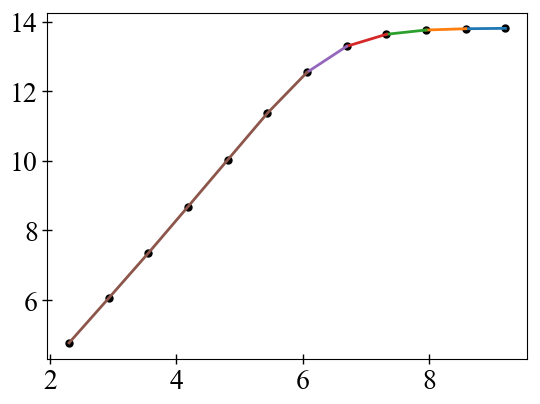

In [13]:
using PyPlot # brings plot_linear_regions into scope
using ChaosTools # you must use ChaosTools as well, for Requires module to work
figure(figsize = (6,4))
plot_linear_regions(x, Ds);

What `generalized_dim` does is calculates the above plot and simply returns the slope of the brown region.

## Kaplan-Yorke Dimension
The Kaplan-Yorke dimension is simply the point where `cumsum(lyapunovs)` becomes zero (interpolated). Kaplan & Yorke have conjectured that this dimension is equal to the information dimension (the dimension when using `α = 1`). But numerical simulations show that this is not always the case...

In [14]:
ls = lyapunovs(towel, 100000; Ttr = 100) # super precise computation

3-element Array{Float64,1}:
  0.431184
  0.376682
 -3.30098 

In [15]:
information_dim(tr) # shorthand for generalized_dim(1, ...)

2.0857728648406897

In [16]:
kaplanyorke_dim(ls)

2.244735099071937